In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import pandas as pd
import time

# HMC Infinite Well

In [2]:
def HMC_infinite_well(epsilon, L, a = 0, b = 1, m = 1, number_of_points = 1000, warmup = 30):
    '''
    Samples from the classical infinite well using a traditional HMC. 
    Inputs: epsilon, stepsize for leapfrog; L, number of integration steps for leapfrog; a =1 , initial point of interval well; b, final point of interval well; number_of_points = 10000, number of points to be sampled; warmup = 30, number of initial iterations to be discarded
    Output: acceptance rate; sampled points
    '''
    coord = []
    discard = 0
    it = 0
    
    x = np.random.normal(loc = (a+b)/2, scale = (b-a)/10) #initially sample the coordinates as a normal
    while x < a or x > b: #if the normal samples the coordinated outside the target support, resamples 
        x = np.random.normal()

    for run in range(number_of_points+warmup): #leapfrog
        p = np.random.normal(scale =  m**(1/2)) #samples p as N(0, sigma)
        H_0 = p**2/(2*m)
        x0 = x
        for integration in range(L):
            p =  p
            x += epsilon*p/m
            if x < a or x > b: #if in forbidden region
                x = x0 #sets x as its previous value
                discard += 1 #increase discard
                break #if in the forbidden region, halts the algorithm
            p = p
        H = p**2/(2*m)
        it += 1
        if it > warmup: #add warm up to the process
            prob = np.random.random()
            if prob < min([1,np.exp(H_0-H)]): #Metropolis-Hastings acceptance step
                coord.append(x)
    
    return ((number_of_points-discard)/(number_of_points), coord)

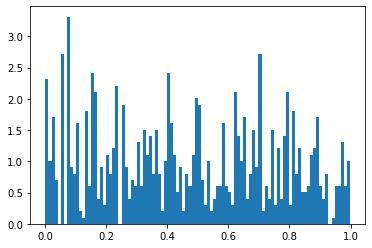

In [3]:
plt.hist(HMC_infinite_well(0.01, 100)[1], bins = 100, density = True)
plt.show()

# RHMC Infinite Well

In [4]:
def RHMC_infinite_well(epsilon, L, a = 0, b = 1, m = 1, number_of_points = 1000, warmup = 30):
    '''
    Samples from the classical infinite well using a RHMC. 
    Inputs: epsilon, stepsize for leapfrog; L, number of integration steps for leapfrog; a =1 , initial point of interval well; b, final point of interval well; number_of_points = 10000, number of points to be sampled; warmup = 30, number of initial iterations to be discarded
    Output: sampled points
    '''
    coord = []
    it = 0
    
    x = np.random.normal(loc = (a+b)/2, scale = (b-a)/10) #initially sample the coordinates as a normal
    while x < a or x > b: #if the normal samples the coordinated outside the target support, resamples 
        x = np.random.normal()

    for run in range(number_of_points+warmup): #leapfrog
        p = np.random.normal(scale =  m**(1/2)) #samples p as N(0, m**2)
        H_0 = p**2/(2*m)
        for integration in range(L):
            p =  p
            x += epsilon*p/m
            while x < a or x > b: #if in forbidden region
                p = -p #refelcts the momentum vector
                if x < a:
                    x = a+(a-x)
                elif x > b:
                    x = b-(x-b)
            p = p
        H = p**2/(2*m)
        it += 1
        if it > warmup:
            prob = np.random.random()
            if prob < min([1,np.exp(H_0-H)]):  #Metropolis-Hastings acceptance step
                coord.append(x)
            else:
                coord.append(coord[-1])
    
    return coord

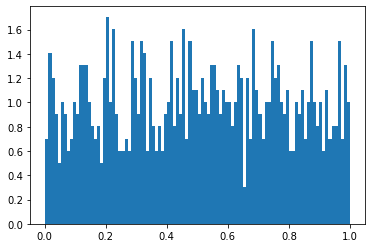

In [5]:
plt.hist(RHMC_infinite_well(0.01, 100), density = True, bins = 100)
plt.show()

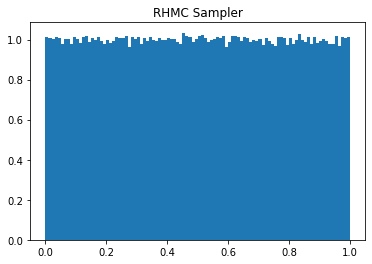

In [6]:
coord = []
for run in range(500):
    coord += RHMC_infinite_well(0.01, 100)
plt.hist(coord, density = True, bins = 100)
plt.title('RHMC Sampler')
plt.show()

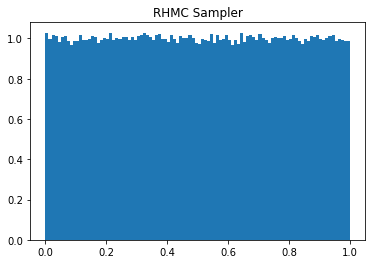

In [7]:
coord = []
for run in range(500):
    coord += RHMC_infinite_well(0.1, 100)
plt.hist(coord, density = True, bins = 100)
plt.title('RHMC Sampler')
plt.show()

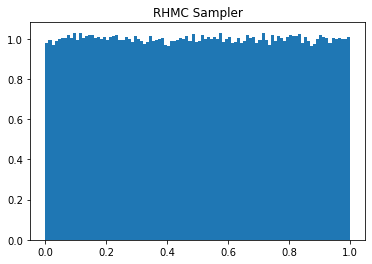

In [8]:
coord = []
for run in range(500):
    coord += RHMC_infinite_well(1, 100)
plt.hist(coord, density = True, bins = 100)
plt.title('RHMC Sampler')
plt.show()

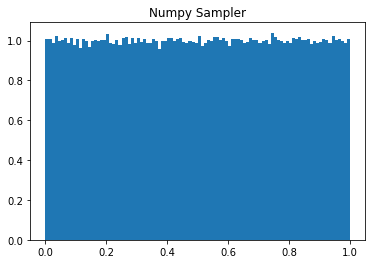

In [9]:
plt.hist(np.random.random(500*1000), density = True, bins = 100)
plt.title('Numpy Sampler')
plt.show()

# Naive HMC Disk

In [10]:
def HMC_disk(epsilon, L, R = 1, r1_0 = 1/2, r2_0 = 1/2, theta1_0 = np.pi, theta2_0 = np.pi, mr1 = 1, mr2 = 1, mtheta1 = 1, mtheta2 = 1, number_of_points = 1000, full = False, warmup = 30):
    '''
    Samples from the unfiform distribution on [0,R] x [0, R] x [0, 2pi] x [0, 2pi] using traditonal HMC, estimating then the mean distance between two points sampled independently and uniform on a disk of radius R. 
    Inputs: epsilon, stepsize for leapfrog; L, number of integration steps for leapfrog; R = 1, radius of the disk which we are interest at; r1_0 = 1, initial point to take r1; r2_0 = 1, initial point to take r2; theta1_0, initial point to take theta1; theta2_0, initial point to take theta2; mr1 = 1; mr2 = 1; mtheta1 = 1; mtheta2 = 1; number_of_points = 10000, number of points to be sampled; full = False, if True, also returns all sampled points;  warmup = 30, number of initial iterations to be discarded
    Output: sampled points
    '''
    distance = []
    it = 0
    discard = 0
    
    #initialize the coordinated
    r1 = r1_0 
    r2 = r2_0
    theta1 = theta1_0
    theta2 = theta2_0
    
    for run in range(number_of_points+warmup): #leapfrog
        pr1 = np.random.normal(scale =  mr1**(1/2)) #samples pr1 as N(0, mr1**2)
        pr2 = np.random.normal(scale =  mr2**(1/2)) #samples pr2 as N(0, mr2**2)
        ptheta1 = np.random.normal(scale =  mtheta1**(1/2)) #samples prtheta1 as N(0, mtheta1**2)
        ptheta2 = np.random.normal(scale =  mtheta2**(1/2)) #samples prtheta2 as N(0, mtheta2**2)
        
        H_0 = pr1**2/(2*mr1)+pr2**2/(2*mr2)+ptheta1**2/(2*mtheta1)+ptheta2**2/(2*mtheta2)
        
        r1_last = r1
        r2_last = r2
        theta1_last = theta1
        theta2_last = theta2
        for integration in range(L):
            #updates in in variables by Hamilton's equations
            pr1 = pr1
            pr2 = pr2
            ptheta1 = ptheta1
            ptheta2 = ptheta2
            
            r1 += epsilon*pr1/mr1
            r2 += epsilon*pr2/mr2
            theta1 += epsilon*ptheta1/mtheta1
            theta2 += epsilon*ptheta2/mtheta2
            
            if r1 < 0 or r1 > R or r2 < 0 or r2 > R or theta1 < 0 or theta1 > 2*np.pi or theta2 < 0 or theta2 > 2*np.pi: #if in forbidden region
                #consider any single situation that might lead to falsification of constraints
                r1 = r1_last
                r2 = r2_last
                theta1 = theta1_last
                theta2 = theta2_last
                discard += 1
                break
                
            pr1 = pr1 #reasign momenta (just a formality, as here the gradient of potential energy is always 0)
            pr2 = pr2
            ptheta1 = ptheta1
            ptheta2 = ptheta2
            
        H = pr1**2/(2*mr1)+pr2**2/(2*mr2)+ptheta1**2/(2*mtheta1)+ptheta2**2/(2*mtheta2)
        it += 1
        if it > warmup:
            prob = np.random.random()
            if prob < min([1,np.exp(H_0-H)]):  #Metropolis-Hastings acceptance step (just a formality as acceptance rate will be, on this case, 1.0)
                distance.append(4/R**2*np.sqrt(r1**2+r2**2-2*r1*r2*np.cos(theta1-theta2))*r1*r2)
            else:
                distance.append(distance[-1])
    
    if full == False: 
        return (np.mean(distance),(number_of_points-discard)/number_of_points)
    else: 
        return (np.mean(distance), (number_of_points-discard)/number_of_points, distance)

In [11]:
HMC_disk(0.005, 100)

(0.8030099229865066, 0.346)

In [12]:
estimation = []
for runs in range(500):
    estimation.append(HMC_disk(0.005, 100)[0])

In [13]:
means = []
for index in range(1, 499):
    means.append(np.mean(estimation[:index]))

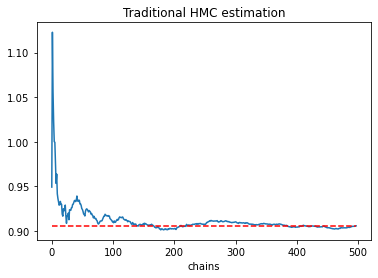

In [14]:
plt.plot(range(len(means)), means)
plt.plot(range(len(means)), 128/(45*np.pi)*np.ones(len(means)), 'r--')
plt.title('Traditional HMC estimation')
plt.xlabel('chains')
plt.show()

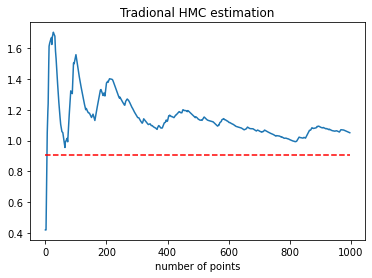

In [15]:
estimation = HMC_disk(0.005, 100, full = True, number_of_points = 1000)[2]
means = []
for index in range(1, 999):
    means.append(np.mean(estimation[:index]))

plt.plot(range(len(means)), means)
plt.plot(range(len(means)), 128/(45*np.pi)*np.ones(len(means)), 'r--')
plt.title('Tradional HMC estimation')
plt.xlabel('number of points')
plt.show()

# RHMC Disk

In [16]:
def RHMC_disk(epsilon, L, R = 1, mr1 = 1, mr2 = 1, mtheta1 = 1, mtheta2 = 1, number_of_points = 1000, full = False, warmup = 30):
    '''
    Samples from the unfiform distribution on [0,R] x [0, R] x [0, 2pi] x [0, 2pi] using a RHMC, estimating then the mean distance between two points sampled independently and uniform on a disk of radius R. 
    Inputs: epsilon, stepsize for leapfrog; L, number of integration steps for leapfrog; R = 1, radius of the disk which we are interest at; r1_0 = 1, initial point to take r1; r2_0 = 1, initial point to take r2; theta1_0, initial point to take theta1; theta2_0, initial point to take theta2; mr1 = 1; mr2 = 1; mtheta1 = 1; mtheta2 = 1; number_of_points = 10000, number of points to be sampled; full = False, if True, also returns all sampled points;  warmup = 30, number of initial iterations to be discarded
    Output: sampled points
    '''
    distance = []
    it = 0
    
    #initialize the coordinated
    r1 = R*np.random.random()
    r2 = R*np.random.random()
    theta1 = 2*np.pi*np.random.random()
    theta2 = 2*np.pi*np.random.random()
    
    for run in range(number_of_points+warmup): #leapfrog
        pr1 = np.random.normal(scale =  mr1**(1/2)) #samples pr1 as N(0, mr1)
        pr2 = np.random.normal(scale =  mr2**(1/2)) #samples pr2 as N(0, mr2)
        ptheta1 = np.random.normal(scale =  mtheta1**(1/2)) #samples prtheta1 as N(0, mtheta1)
        ptheta2 = np.random.normal(scale =  mtheta2**(1/2)) #samples prtheta2 as N(0, mtheta2)
        
        H_0 = pr1**2/(2*mr1)+pr2**2/(2*mr2)+ptheta1**2/(2*mtheta1)+ptheta2**2/(2*mtheta2)
        for integration in range(L):
            #updates in in variables by Hamilton's equations
            pr1 = pr1
            pr2 = pr2
            ptheta1 = ptheta1
            ptheta2 = ptheta2
            
            r1 += epsilon*pr1/mr1
            r2 += epsilon*pr2/mr2
            theta1 += epsilon*ptheta1/mtheta1
            theta2 += epsilon*ptheta2/mtheta2
            
            while r1 < 0 or r1 > R or r2 < 0 or r2 > R or theta1 < 0 or theta1 > 2*np.pi or theta2 < 0 or theta2 > 2*np.pi: #if in forbidden region
                #consider any single situation that might lead to falsification of constraints
                if r1 < 0:
                    pr1 = -pr1 #always invert the momentum of a component that breaks the constraints
                    r1 = -r1
                elif r1 > R:
                    pr1 = -pr1
                    r1 = R-(r1-R)
                elif r2 < 0:
                    pr2 = -pr2
                    r2 = -r2
                elif r2 > R:
                    pr2 = -pr2
                    r2 = R-(r2-R)
                elif theta1 < 0:
                    ptheta1 = -ptheta1
                    theta1 = -theta1
                elif theta1 > 2*np.pi:
                    ptheta1 = -ptheta1
                    theta1 = 2*np.pi-(theta1-2*np.pi)
                elif theta2 < 0:
                    ptheta2 = -ptheta2
                    theta2 = -theta2
                elif theta2 > 2*np.pi:
                    ptheta2 = -ptheta2
                    theta2 = 2*np.pi-(theta2-2*np.pi)
                
            pr1 = pr1 #reasign momenta (just a formality, as here the gradient of potential energy is always 0)
            pr2 = pr2
            ptheta1 = ptheta1
            ptheta2 = ptheta2
            
        H = pr1**2/(2*mr1)+pr2**2/(2*mr2)+ptheta1**2/(2*mtheta1)+ptheta2**2/(2*mtheta2)
        it += 1
        if it > warmup:
            prob = np.random.random()
            if prob < min([1,np.exp(H_0-H)]):  #Metropolis-Hastings acceptance step (just a formality as acceptance rate will be, on this case, 1.0)
                distance.append(4/R**2*np.sqrt(r1**2+r2**2-2*r1*r2*np.cos(theta1-theta2))*r1*r2)
            else:
                distance.append(distance[-1])
    
    if full == False: 
        return (np.mean(distance))
    else: 
        return (np.mean(distance), distance)

In [17]:
RHMC_disk(0.01, 100, R = 1, mr1 = 1, mr2 = 1, number_of_points =  10)

1.1719057304217888

In [18]:
estimation = []
for runs in range(500):
    estimation.append(RHMC_disk(0.01, 100))

In [19]:
means = []
for index in range(1, 499):
    means.append(np.mean(estimation[:index]))

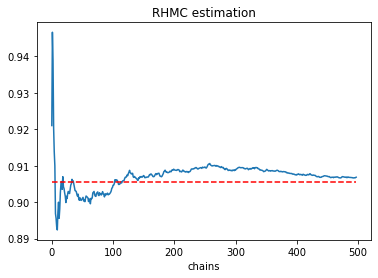

In [20]:
plt.plot(range(len(means)), means)
plt.plot(range(len(means)), 128/(45*np.pi)*np.ones(len(means)), 'r--')
plt.title('RHMC estimation')
plt.xlabel('chains')
plt.show()

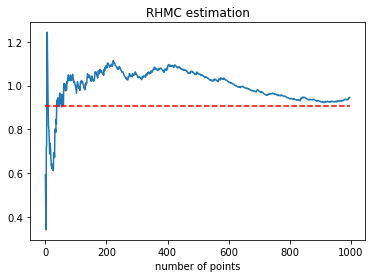

In [21]:
estimation = RHMC_disk(0.01, 100, full = True, number_of_points = 1000)[1]
means = []
for index in range(1, 999):
    means.append(np.mean(estimation[:index]))

plt.plot(range(len(means)), means)
plt.plot(range(len(means)), 128/(45*np.pi)*np.ones(len(means)), 'r--')
plt.title('RHMC estimation')
plt.xlabel('number of points')
plt.show()

In [22]:
def Gelman_RHMC_disk(epsilon, L, R = 1, mr1 = 1, mr2 = 1, mtheta1 = 1, mtheta2 = 1, number_of_points = 1000, warmup = 30, number_of_chains = 100):
    '''
    Computes the Gelman-Rubin coefficient R_hat for a Markov method of RHMC for the mean distances of points sampled uniformly in a disk
    Inputs: epsilon, stepsize for leapfrog; L, number of integration steps for leapfrog; R = 1, radius of the disk which we are interest at; r1_0 = 1, initial point to take r1; r2_0 = 1, initial point to take r2; theta1_0, initial point to take theta1; theta2_0, initial point to take theta2; mr1 = 1; mr2 = 1; mtheta1 = 1; mtheta2 = 1; number_of_points = 10000, number of points to be sampled;  warmup = 30, number of initial iterations to be discarded; number of chains used in computing R_hat
    Outputs: the coefficient R_hat
    '''
    set_of_chains = np.array(RHMC_disk(epsilon, L, R = R, mr1 = mr1, mr2 = mr2, mtheta1 = mtheta1, mtheta2 = mtheta2, number_of_points = number_of_points, full = True, warmup = warmup)[1])
    for chain in range(number_of_chains-1):
        new_chain = np.array(RHMC_disk(epsilon, L, R = R, mr1 = mr1, mr2 = mr2, mtheta1 = mtheta1, mtheta2 = mtheta2, number_of_points = number_of_points, full = True, warmup = warmup)[1])
        set_of_chains = np.vstack((set_of_chains, new_chain))
    
    #takes the mean of all chains' entries
    full_mean = np.mean(set_of_chains)
    
    #computes the summation part of the definition of B
    summation_b = 0
    for index in range(number_of_points):
        summation_b += (np.mean(set_of_chains[:,index]-full_mean))**2
    #computes B
    b = number_of_points/(number_of_chains-1)*summation_b
    
    #computes the summation part of the definition of W
    summation_w = 0
    for index in range(number_of_points):
        mean_index  = np.mean(set_of_chains[:,index])             
        for chain in range(number_of_chains):
            summation_w += (set_of_chains[chain,index]-mean_index)**2
    #computes W
    w = 1/(number_of_chains*(number_of_points-1))*summation_w
    
    R_hat = np.sqrt(((1-1/number_of_points)*w+b/number_of_points)/w)
    return R_hat

In [23]:
Gelman_RHMC_disk(0.01, 100, number_of_points = 1000, number_of_chains = 100)

1.0524861470758535

In [24]:
def Geweke_RHMC_disk(epsilon, L, R = 1, mr1 = 1, mr2 = 1, mtheta1 = 1, mtheta2 = 1, number_of_points = 1000, warmup = 30, number_of_chains = 100, na = 0.5, nb = 0.1):
    na_int = int(na*number_of_points)
    nb_int = int(nb*number_of_points)
    
    diff = []
    for chain in range(number_of_chains):
        estimation = np.array(RHMC_disk(epsilon, L, R = R, mr1 = mr1, mr2 = mr2, mtheta1 = mtheta1, mtheta2 = mtheta2, number_of_points = number_of_points, full = True, warmup = warmup)[1])
        diff.append(np.mean(estimation[:nb_int])-np.mean(estimation[na_int:]))
    plt.hist(diff, bins = int(number_of_chains/10))
    return

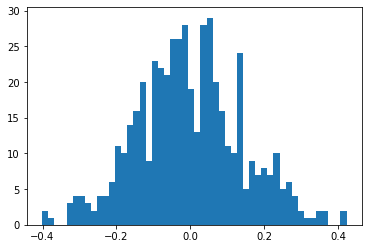

In [25]:
Geweke_RHMC_disk(0.01, 100, number_of_points = 1000, number_of_chains = 500)

In [26]:
def ACF_disk(number_of_chains = 100):
    '''
    Computes the autocorrelation factor for 40 lags and number_of_chains runs
    Input = number_of_chains = 100, number of runs to be computed
    '''
    mean, distribution  = RHMC_disk(0.01, 100, number_of_points = 1000, full = True)
    n = len(distribution)
    variance = np.std(distribution)**2

    autocorrelations = []
    for k in range(0, 40):
        sum_k = 0
        for j in range(n-k-1):
            sum_k += (distribution[j]-mean)*(distribution[j+k]-mean)
        autocorrelations.append(sum_k/((n-k)*variance))
    total_autocorrelations = np.array(autocorrelations)

    for chain in range(number_of_chains-1):
        mean, distribution  = RHMC_disk(0.01, 100, number_of_points = 1000, full = True)
        variance = np.std(distribution)**2

        autocorrelations = []
        for k in range(0, 40):
            sum_k = 0
            for j in range(n-k-1):
                sum_k += (distribution[j]-mean)*(distribution[j+k]-mean)
            autocorrelations.append(sum_k/((n-k)*variance))
        total_autocorrelations = np.vstack((total_autocorrelations, autocorrelations))
    return np.mean(total_autocorrelations, axis = 0)

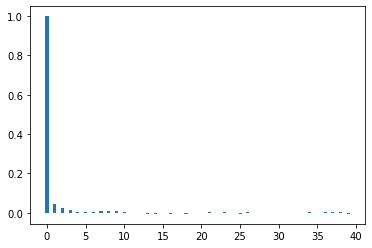

In [27]:
plt.bar(range(40), ACF_disk(),  width = 0.4) 
plt.show()

In [28]:
def inefficiency_disk(k = 20, n = 100000, alpha = 0.95):
    '''
    Computes the inefficiency factor of the method using the batch method and confidence levels for estimation
    Input: k = 20, number of batches, n = 100000, number of samples; alpha = 0.95, confidence level to be computed
    Ouput: inefficiency factor tau**2; lower bound of confidence level; upper bound of confidence level
    '''
    mean, distribution  = RHMC_disk(0.01, 100, number_of_points = n, full = True)
    m = int(n/k)
    summation = 0
    
    for j in range(k):
        mean_batch = np.mean(distribution[j*m:(j+1)*m])
        summation += (mean_batch-mean)**2
    
    tau_sqrd_overn = summation/(k*(k-1))
    
    return tau_sqrd_overn*n, 128/(45*np.pi)-np.sqrt(tau_sqrd_overn)*t.ppf(1-(1-alpha)/2, k-1), 128/(45*np.pi)+np.sqrt(tau_sqrd_overn)*t.ppf(1-(1-alpha)/2, k-1)

In [29]:
inefficiency_disk()

(2.14319557453744, 0.8957252036022959, 0.9151043711321577)

In [30]:
def inefficiency_calculator(data, k = 20):
    '''
    Computes the inefficiency factor for a general dataset
    Input: data; k = 20, number of batches
    '''
    mean  = np.mean(data)
    n =  len(data)
    m = int(n/k)
    summation = 0
    
    for j in range(k):
        mean_batch = np.mean(data[j*m:(j+1)*m])
        summation += (mean_batch-mean)**2
    
    tau_sqrd_overn = summation/(k*(k-1))
    
    return tau_sqrd_overn

In [31]:
start = time.time()
bias = []
variance = []
mcse = []
for R in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    theoretical = 128*R/(45*np.pi)
    estimation = []
    for run in range(500):
        estimation += RHMC_disk(0.01, 100, R = R, mr1 = 1/R**2, mr2 = 1/R**2, mtheta1 = 1, mtheta2 = 1, number_of_points = 1000, full = True, warmup = 30)[1]
    bias.append(np.mean(estimation)-theoretical)
    variance.append(np.std(estimation)**2)
    mcse.append(np.sqrt(inefficiency_calculator(estimation)))
end = time.time()

In [32]:
print(end-start)

331.44016218185425


In [33]:
307.2881848812103/60

5.121469748020172

In [34]:
data = {'Bias':bias, 'Variance':variance, 'MCSE': mcse} 
df = pd.DataFrame(data, index = [0.01,0.1,1,10,100,1000,10000]) 
df

,Bias,Variance,MCSE
0.01,-0.000001,1.315419e-04,0.000012
0.10,0.000042,1.314747e-02,0.000186
1.00,-0.001736,1.309230e+00,0.001579
10.00,0.013576,1.313761e+02,0.018014
100.00,-0.261105,1.306275e+04,0.180661
1000.00,0.419884,1.314343e+06,1.908564
10000.00,4.925451,1.309968e+08,21.492320


# Generalized RHMC 2D Disk

In [35]:
def polar(x,y):
    r = np.sqrt(x**2+y**2)
    if x == 0 and y > 0:
        theta = np.pi/2
    elif x == 0 and y < 0:
        theta = 3/2*np.pi
    elif x == 0 and y == 0:
        theta = 0
    else:
        angle = np.arctan(y/x)  #first quadrant
        if x > 0 and y >= 0:
            theta = angle
        elif x > 0 and y < 0: #second quadrant
            theta = 2*np.pi+angle
        elif x < 0 and y > 0: #third quadrant
            theta = np.pi+angle
        elif x < 0 and y < 0: #fourth quadrant
            theta = np.pi+angle
    
    return (r, theta)

In [36]:
def general_RHMC(epsilon, L, R = 1, correction_factor = 1, m = 1, number_of_points = 1000, warmup = 30, number_of_collisions = False):
    '''
    Samples from the unfiform distribution on a disk of radius R. 
    Inputs: epsilon, stepsize for leapfrog; L, number of integration steps for leapfrog; R = 1, radius of the disk which we are interest at; correction_factor = number to multiply the initial sapled value of x and y so to go over the full circle; m = 1; number_of_points = 10000, number of points to be sampled;  warmup = 30, number of initial iterations to be discarded; number_of_collisions = False, if true, keeps track of avarage the number of collisions with the boundary per integration time 
    Output: sampled points
    '''
    distribution = []
    it = 0
    if number_of_collisions == True:
        col = 0
    #initialize the coordinated
    x, y = correction_factor*np.random.normal(), correction_factor*np.random.normal()
    while polar(x,y)[0]>R:
        x, y = correction_factor*np.random.random(), correction_factor*np.random.random()
    
    for run in range(number_of_points+warmup): #leapfrog
        px = np.random.normal(scale =  m**(1/2)) #samples px as N(0, m)
        py = np.random.normal(scale =  m**(1/2)) #samples py as N(0, m)
       
        H_0 = px**2/(2*m)+py**2/(2*m)
        
        for integration in range(L):
            #updates in in variables by Hamilton's equations
            px = px
            py = py
            
            x += epsilon*px/m
            y += epsilon*py/m
            
            r, theta = polar(x,y)
            while r > R: #if in forbidden region
                vx = px/m
                vy = py/m 
                vr = (x*vx+y*vy)/(np.sqrt(x**2+y**2))
                vtheta = (-vx*y+x*vy)/(x**2+y**2)
                delta = (r-R)/vr

                vr = -vr
                vx = vr*np.cos(theta)-R*vtheta*np.sin(theta)
                vy = vr*np.sin(theta)+R*vtheta*np.cos(theta)
                px = vx*m
                py = vy*m
                x = R*np.cos(theta)+delta*px/m
                y = R*np.sin(theta)+delta*py/m
                r, theta = polar(x,y)
                if number_of_collisions == True:
                    col += 1
                
            px = px #reasign momenta (just a formality, as here the gradient of potential energy is always 0)
            py = py
            
        H =  px**2/(2*m)+py**2/(2*m)
        it += 1
        if it > warmup:
            prob = np.random.random()
            if prob < min([1,np.exp(H_0-H)]):  #Metropolis-Hastings acceptance step (just a formality as acceptance rate will be, on this case, 1.0)
                distribution.append([x,y])
            else:
                distribution.append(distribution[-1])
                print(H_0, H)
    
    if number_of_collisions == True:
        print(col/number_of_points)
    return np.array(distribution)

In [37]:
distribution = np.linalg.norm(general_RHMC(0.01, 100, R = 1)-general_RHMC(0.01, 100, R = 1), axis = 1)
np.mean(distribution), np.std(distribution)

(0.9091349449033373, 0.40831580008742197)

In [38]:
_ = general_RHMC(0.01, 100, R = 1, number_of_points = 100000, number_of_collisions = True)

0.78764


In [39]:
epsilon = 0.1
x = 0.4
y = 0
px = 1
py = 1
m = 1
R = 1

xs = []
ys =[]
for integration in range(100):
            #updates in in variables by Hamilton's equations
    px = px
    py = py

    x += epsilon*px/m
    y += epsilon*py/m

    r, theta = polar(x,y)
    while r > R: #if in forbidden region
        vx = px/m
        vy = py/m 
        vr = (x*vx+y*vy)/(np.sqrt(x**2+y**2))
        vtheta = (-vx*y+x*vy)/(x**2+y**2)
        delta = (r-R)/vr

        vr = -vr
        vx = vr*np.cos(theta)-R*vtheta*np.sin(theta)
        vy = vr*np.sin(theta)+R*vtheta*np.cos(theta)
        px = vx*m
        py = vy*m
        x = R*np.cos(theta)+delta*px/m
        y = R*np.sin(theta)+delta*py/m
        r, theta = polar(x,y)

    px = px #reasign momenta (just a formality, as here the gradient of potential energy is always 0)
    py = py
    xs.append(x)
    ys.append(y)

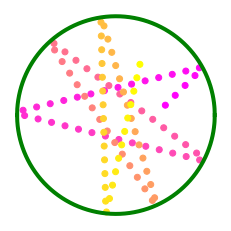

In [40]:
plt.scatter(xs, ys, cmap = 'spring', c = range(len(xs)))
x = np.linspace(-1,1,1000)
plt.plot(x, np.sqrt(1-x**2), c = 'green', linewidth = 4)
plt.plot(x, -np.sqrt(1-x**2),  c = 'green', linewidth = 4)
plt.axis('off')
plt.gca().set_aspect('equal')
plt.show()

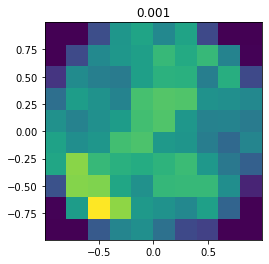

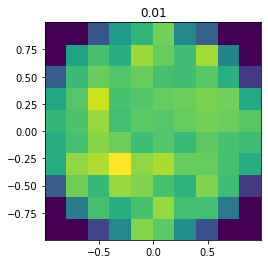

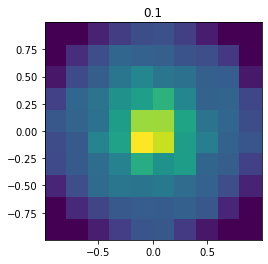

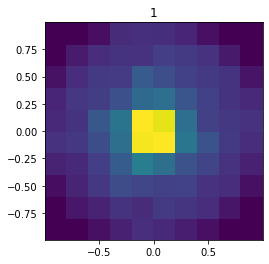

In [41]:
for epsilon in [0.001, 0.01, 0.1, 1]:
    coord = general_RHMC(epsilon, 100, m = 1, number_of_points = 10000, warmup = 30)
    plt.hist2d(coord[:,0],coord[:,1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(epsilon)
    plt.savefig('hist'+str(epsilon)+'.png')
    plt.show()

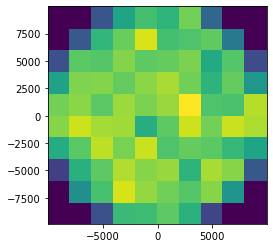

In [42]:
coord = general_RHMC(0.01, 100, R = 10000, m = 1/10000**2, number_of_points = 10000, warmup = 30)
plt.hist2d(coord[:,0],coord[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [43]:
coord = general_RHMC(0.01, 100, m = 1, number_of_points = 10000, warmup = 30)
len(coord[np.linalg.norm(coord, axis = 1)<1/np.sqrt(2)])/len(coord)

0.5064

In [44]:
coord = general_RHMC(0.1, 100, m = 1, number_of_points = 10000, warmup = 30)
len(coord[np.linalg.norm(coord, axis = 1)<1/np.sqrt(2)])/len(coord)

0.6568

In [45]:
coord = general_RHMC(1, 100, m = 1, number_of_points = 10000, warmup = 30)
len(coord[np.linalg.norm(coord, axis = 1)<1/np.sqrt(2)])/len(coord)

0.7177

In [46]:
estimation = []
for runs in range(500):
    estimation.append(np.mean(np.linalg.norm(general_RHMC(0.01, 100)-general_RHMC(0.01, 100), axis = 1)))

In [47]:
means = []
for index in range(1, 499):
    means.append(np.mean(estimation[:index]))

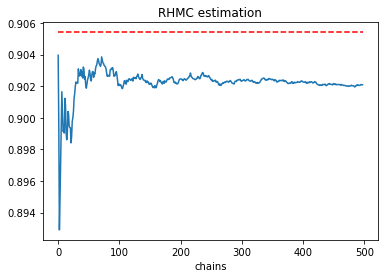

In [48]:
plt.plot(range(len(means)), means)
plt.plot(range(len(means)), 128/(45*np.pi)*np.ones(len(means)), 'r--')
plt.title('RHMC estimation')
plt.xlabel('chains')
plt.show()

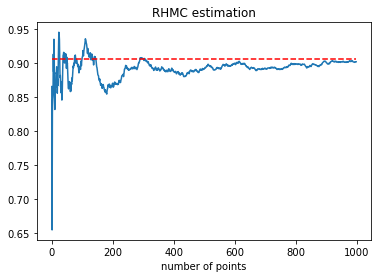

In [49]:
estimation = np.linalg.norm(general_RHMC(0.01, 100)-general_RHMC(0.01, 100), axis = 1)
means = []
for index in range(1, 999):
    means.append(np.mean(estimation[:index]))

plt.plot(range(len(means)), means)
plt.plot(range(len(means)), 128/(45*np.pi)*np.ones(len(means)), 'r--')
plt.title('RHMC estimation')
plt.xlabel('number of points')
plt.show()

In [50]:
def Gelman_general_RHMC(epsilon, L, R = 1, correction_factor = 1, m = 1, number_of_points = 1000, warmup = 30, number_of_chains = 100):
    '''
    Computes the Gelman-Rubin coefficient R_hat for a Markov method of RHMC for the mean distances of points sampled uniformly in a disk
    Inputs: epsilon, stepsize for leapfrog; L, number of integration steps for leapfrog; R = 1, radius of the disk which we are interest at; r1_0 = 1, initial point to take r1; r2_0 = 1, initial point to take r2; theta1_0, initial point to take theta1; theta2_0, initial point to take theta2; mr1 = 1; mr2 = 1; mtheta1 = 1; mtheta2 = 1; number_of_points = 10000, number of points to be sampled;  warmup = 30, number of initial iterations to be discarded; number of chains used in computing R_hat
    Outputs: the coefficient R_hat
    '''
    set_of_chains = np.array(np.linalg.norm(general_RHMC(epsilon, L, R = R, correction_factor = correction_factor, m = m, number_of_points = number_of_points, warmup = warmup)-general_RHMC(epsilon, L, R = R, correction_factor = correction_factor, m = m, number_of_points = number_of_points, warmup = warmup), axis = 1))
    for chain in range(number_of_chains-1):
        new_chain = np.array(np.linalg.norm(general_RHMC(epsilon, L, R = R, correction_factor = correction_factor, m = m, number_of_points = number_of_points, warmup = warmup)-general_RHMC(epsilon, L, R = R, correction_factor = correction_factor, m = m, number_of_points = number_of_points, warmup = warmup), axis = 1))
        set_of_chains = np.vstack((set_of_chains, new_chain))
    
    #takes the mean of all chains' entries
    full_mean = np.mean(set_of_chains)
    
    #computes the summation part of the definition of B
    summation_b = 0
    for index in range(number_of_points):
        summation_b += (np.mean(set_of_chains[:,index]-full_mean))**2
    #computes B
    b = number_of_points/(number_of_chains-1)*summation_b
    
    #computes the summation part of the definition of W
    summation_w = 0
    for index in range(number_of_points):
        mean_index  = np.mean(set_of_chains[:,index])             
        for chain in range(number_of_chains):
            summation_w += (set_of_chains[chain,index]-mean_index)**2
    #computes W
    w = 1/(number_of_chains*(number_of_points-1))*summation_w
    
    R_hat = np.sqrt(((1-1/number_of_points)*w+b/number_of_points)/w)
    return R_hat

In [51]:
Gelman_general_RHMC(0.01, 100)

1.0455050589176342

In [52]:
def Geweke_general_RHMC(epsilon, L, R = 1, correction_factor = 1, m = 1, number_of_points = 1000, warmup = 30, number_of_chains = 100, na = 0.5, nb = 0.1):
    na_int = int(na*number_of_points)
    nb_int = int(nb*number_of_points)
    
    diff = []
    for chain in range(number_of_chains):
        estimation = np.array(np.linalg.norm(general_RHMC(epsilon, L, R = R, correction_factor = correction_factor, m = m, number_of_points = number_of_points, warmup = warmup)-general_RHMC(epsilon, L, R = R, correction_factor = correction_factor, m = m, number_of_points = number_of_points, warmup = warmup), axis = 1))
        diff.append(np.mean(estimation[:nb_int])-np.mean(estimation[na_int:]))
    plt.hist(diff, bins = int(number_of_chains/10))
    return

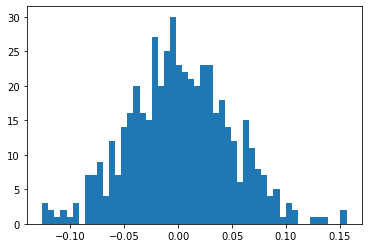

In [53]:
Geweke_general_RHMC(0.01, 100, number_of_chains = 500)

In [54]:
def ACF_general_RHMC(number_of_chains = 100):
    '''
    Computes the autocorrelation factor for 40 lags and number_of_chains runs
    Input = number_of_chains = 100, number of runs to be computed
    '''
    distribution  = np.linalg.norm(general_RHMC(0.01, 100, number_of_points = 1000)-general_RHMC(0.01, 100, number_of_points = 1000), axis = 1)
    mean = np.mean(distribution)
    variance = np.std(distribution)**2
    n = len(distribution)
    
    #calculates autocorrelation for a single chain
    autocorrelations = []
    for k in range(0, 40):
        sum_k = 0
        for j in range(n-k-1):
            sum_k += (distribution[j]-mean)*(distribution[j+k]-mean)
        autocorrelations.append(sum_k/((n-k)*variance))
    total_autocorrelations = np.array(autocorrelations)
    
    #calculates autocorrelation for other chains and avarage the result
    for chain in range(number_of_chains-1):
        distribution  = np.linalg.norm(general_RHMC(0.01, 100, number_of_points = 1000)-general_RHMC(0.01, 100, number_of_points = 1000), axis = 1)
        mean = np.mean(distribution)
        variance = np.std(distribution)**2

        autocorrelations = []
        for k in range(0, 40):
            sum_k = 0
            for j in range(n-k-1):
                sum_k += (distribution[j]-mean)*(distribution[j+k]-mean)
            autocorrelations.append(sum_k/((n-k)*variance))
        total_autocorrelations = np.vstack((total_autocorrelations, autocorrelations))
    return np.mean(total_autocorrelations, axis = 0)

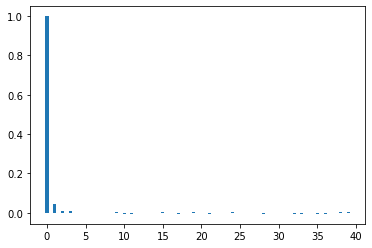

In [55]:
plt.bar(range(40), ACF_general_RHMC(),  width = 0.4) 
plt.show()

In [56]:
def inefficiency_general_RHMC(k = 20, n = 100000, alpha = 0.95):
    '''
    Computes the inefficiency factor of the method using the batch method and confidence levels for estimation
    Input: k = 20, number of batches, n = 100000, number of samples; alpha = 0.95, confidence level to be computed
    Ouput: inefficiency factor tau**2; lower bound of confidence level; upper bound of confidence level
    '''
    distribution  = np.linalg.norm(general_RHMC(0.01, 100, number_of_points = n)-general_RHMC(0.01, 100, number_of_points = n), axis = 1)
    m = int(n/k)
    mean = np.mean(distribution)
    summation = 0
    
    for j in range(k):
        mean_batch = np.mean(distribution[j*m:(j+1)*m])
        summation += (mean_batch-mean)**2
    
    tau_sqrd_overn = summation/(k*(k-1))
    
    return tau_sqrd_overn*n, 128/(45*np.pi)-np.sqrt(tau_sqrd_overn)*t.ppf(1-(1-alpha)/2, k-1), 128/(45*np.pi)+np.sqrt(tau_sqrd_overn)*t.ppf(1-(1-alpha)/2, k-1)

In [57]:
inefficiency_general_RHMC()

(0.20877575656472686, 0.9023905612987305, 0.9084390134357231)

In [58]:
start = time.time()
bias = []
variance = []
mcse = []
for R in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    theoretical = 128*R/(45*np.pi)
    estimation = []
    for run in range(500):
        estimation += list(np.linalg.norm(general_RHMC(0.01, 100, R = R, correction_factor = R, m = 1/R**2, number_of_points = 1000, warmup = 30)-general_RHMC(0.01, 100, R = R, correction_factor = R, m = 1/R**2, number_of_points = 1000, warmup = 30), axis = 1))
    bias.append(np.mean(estimation)-theoretical)
    variance.append(np.std(estimation)**2)
    mcse.append(np.sqrt(inefficiency_calculator(estimation)))
end = time.time()

In [59]:
print(end-start)

4008.9548242092133


In [60]:
data = {'Bias':bias, 'Variance':variance, 'MCSE': mcse} 
df = pd.DataFrame(data, index = [0.01,0.1,1,10,100,1000,10000]) 
df

,Bias,Variance,MCSE
0.01,-0.000027,1.791759e-05,0.000005
0.10,-0.000314,1.790880e-03,0.000055
1.00,-0.003787,1.791900e-01,0.000659
10.00,-0.037626,1.795050e+01,0.007533
100.00,-0.295686,1.789532e+03,0.078325
1000.00,-3.660029,1.792610e+05,0.624920
10000.00,-43.154879,1.791021e+07,6.469156
